In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

In [3]:
import torch
from torch import nn

In [4]:
torch.manual_seed(52)

In [5]:
import os
import sys
import tqdm

In [6]:
# Add parent dir to interpreter path
nb_dir = os.path.split(os.getcwd())[0]
print("Notebook dir {:}".format(nb_dir))
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
print("Python interpreter path:")
for path in sys.path:
    print(path)

Notebook dir /home/manifold/Documents/etudes/map511-p3a
Python interpreter path:

/home/manifold/Documents/etudes/map511-p3a/notebooks
/home/manifold/miniconda3/envs/pytorch/lib/python37.zip
/home/manifold/miniconda3/envs/pytorch/lib/python3.7
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/lib-dynload
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/pointprocesses-0.4.1-py3.7-linux-x86_64.egg
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/torchvision-0.2.1-py3.7.egg
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/IPython/extensions
/home/manifold/.ipython
/home/manifold/Documents/etudes/map511-p3a


# Loading synthetic data

We will be loading simulated Hawkes data.

In [140]:
import glob
import pickle

SYNTH_DATA_FILES = glob.glob('../data/simulated/*')
print("Available files:")
for s in SYNTH_DATA_FILES:
    print(s)

from utils.load_synth_data import process_loaded_sequences, one_hot_embedding

Available files:
../data/simulated/hawkes_synth_data_1d.pkl
../data/simulated/hawkes_synth_data_2d.pkl
../data/simulated/README.md


In [115]:
process_dim = 2
# Load data simulated using tick
print("Loading {}-dimensional".format(process_dim))
choose_file_index = 1
chosen_file = SYNTH_DATA_FILES[choose_file_index]
print("Data file: {}".format(chosen_file))
with open(SYNTH_DATA_FILES[process_dim-1], "rb") as f:
    loaded_hawkes_data = pickle.load(f)

print(loaded_hawkes_data.keys())

mu = loaded_hawkes_data['mu']
alpha = loaded_hawkes_data['alpha']
decay = loaded_hawkes_data['decay']
tmax = loaded_hawkes_data['tmax']
print(mu)
print(decay)
print(tmax)

times_tensor, seq_types, seq_lengths = process_loaded_sequences(
    loaded_hawkes_data)

onehot_types = one_hot_embedding(seq_types, process_dim+1)

# Neural network

We are going for a recurrent neural structure that can learn from previous events. The intensity process of our neural model will be of the form

$$
    \lambda_t = f\left(W_{\lambda} h(t)\right)
$$

with $f$ a positive-valued activation function (such as ReLU) and $h(t)\in\mathbb R^D$ a continuous hidden state, computed as
\begin{equation}
    h(t) = h_{i}e^{-\delta_i(t-t_{i-1})},\quad \forall t\in(t_{i-1},t_i]
\end{equation}

Network update formulas: the jump and decay parameters on $(t_i,t_{i+1}]$ are given by
$$
\begin{align*}
    h_{i+1}      &= \tanh(W_{hh}h(t_i) + W_{xh}x_i + b_{h}) \\
    \delta_{i+1} &= \sigma(W_{hd} h(t_i) + W_{xd}x_i + b_{d})
\end{align*}
$$

In [129]:
from models.decayrnn import HawkesDecayRNN, generate_sequence
from train_functions import train_decayrnn, plot_loss
process_dim = 2
hidden_size = 8
model = HawkesDecayRNN(process_dim, hidden_size)
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.018)

In [130]:
# define training data
train_size = 1000
print("Train size %d" % train_size)

train_times_tensor = times_tensor[:, :train_size]
train_onehot_types = onehot_types[:, :train_size]
train_seq_lengths = seq_lengths[:train_size]
print("Train event times shape {}".format(train_times_tensor.shape))
print("Train event types shape {}".format(train_onehot_types.shape))
print("Train seq lengths shape {}".format(train_seq_lengths.shape))

Train size 1000
Train event times shape torch.Size([167, 1000])
Train event types shape torch.Size([167, 1000, 3])
Train seq lengths shape torch.Size([1000])


In [131]:
# Training parameters
BATCH_SIZE = 24
EPOCHS = 20

loss_hist = train_decayrnn(model, optimizer, train_times_tensor,
                           train_onehot_types, train_seq_lengths, tmax,
                           BATCH_SIZE, EPOCHS, use_jupyter=True)

Batch size 24
Number of epochs 20


epoch 1: train loss 139.1181


epoch 2: train loss 86.1161


epoch 3: train loss 69.5188


epoch 4: train loss 58.6217


epoch 5: train loss 51.3031


epoch 6: train loss 46.2896


epoch 7: train loss 42.7897


epoch 8: train loss 40.3060


epoch 9: train loss 38.5124


epoch 10: train loss 37.1969


epoch 11: train loss 36.2168


epoch 12: train loss 35.4728


epoch 13: train loss 34.8994


epoch 14: train loss 34.4512


epoch 15: train loss 34.0945


epoch 16: train loss 33.8074


epoch 17: train loss 33.5722


epoch 18: train loss 33.3763


epoch 19: train loss 33.2123


epoch 20: train loss 33.0709


In [132]:
model.trained_epochs

20

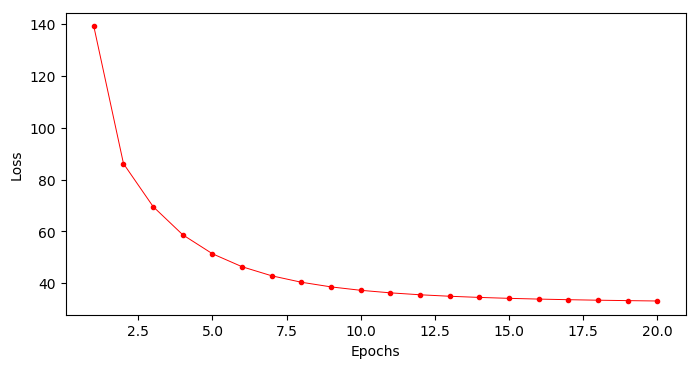

In [133]:
_ = plot_loss(EPOCHS, loss_hist)

## Save to file

In [18]:
import datetime

# Model file dump
SAVED_MODELS_PATH = os.path.abspath('../saved_models')
os.makedirs(SAVED_MODELS_PATH, exist_ok=True)
print("Saved models directory: {}".format(SAVED_MODELS_PATH))

date_format = "%Y%m%d-%H%M%S"
now_timestamp = datetime.datetime.now().strftime(date_format)
extra_tag = "{}d".format(process_dim)
filename_base = "{}-{}-{}".format(model.__class__.__name__, extra_tag, now_timestamp)
filename_model_save = filename_base + ".pth"
filepath = os.path.join(SAVED_MODELS_PATH, filename_model_save)
print("Saving model state dict to {}".format(filepath))
torch.save(model.state_dict(), filepath)

Saved models directory: /home/manifold/Documents/etudes/map511-p3a/saved_models
Saving model state dict to /home/manifold/Documents/etudes/map511-p3a/saved_models/HawkesDecayRNN-1d-20181127-090212.pth


## Model evaluation

Now we perform model evaluation steps.

### Load saved model

In [109]:
from models.decayrnn import HawkesDecayRNN

MODEL_FILES = glob.glob("../saved_models/*.pth")
print(MODEL_FILES)

['../saved_models/HawkesDecayRNN-2d-20181127-214226.pth']


In [112]:
process_dim = 2

hidden_size = 8
print("Hidden size: {}".format(hidden_size))
model = HawkesDecayRNN(process_dim, hidden_size)

model.load_state_dict(torch.load(MODEL_FILES[0], map_location={"cuda:0": "cpu"}))
model.eval()

Hidden size: 8


HawkesDecayRNN(
  (rnn_layer): RNNCell(3, 8)
  (decay_layer): Sequential(
    (0): Linear(in_features=11, out_features=1, bias=True)
    (1): Softplus(beta=3.0, threshold=20)
  )
  (intensity_layer): Sequential(
    (0): Linear(in_features=8, out_features=3, bias=False)
    (1): Softplus(beta=3.0, threshold=20)
  )
)

### Sequence generation and sequence length distribution

In [134]:
# Build a statistic for the no. of events
gen_seq_lengths = []
gen_seq_types_lengths = []
n_gen_seq = 1000 # number of generated sequences
for i in range(n_gen_seq):
    (gen_event_times, gen_event_types,
     gen_event_intens, gen_event_decay) = generate_sequence(model, tmax)
    gen_seq_lengths.append(len(gen_event_times) - 1)
    gen_seq_types_lengths.append([
        (gen_event_types == i).sum() for i in range(inp_size)
    ])
gen_seq_lengths = np.array(gen_seq_lengths)
gen_seq_types_lengths = np.array(gen_seq_types_lengths)

print("Mean generated sequence length: {}".format(gen_seq_lengths.mean()))
print("Generated sequence length std. dev: {}".format(gen_seq_lengths.std()))
MODEL_NAME = "Decay-RNN"

Mean generated sequence length: 119.978
Generated sequence length std. dev: 11.862947188620542


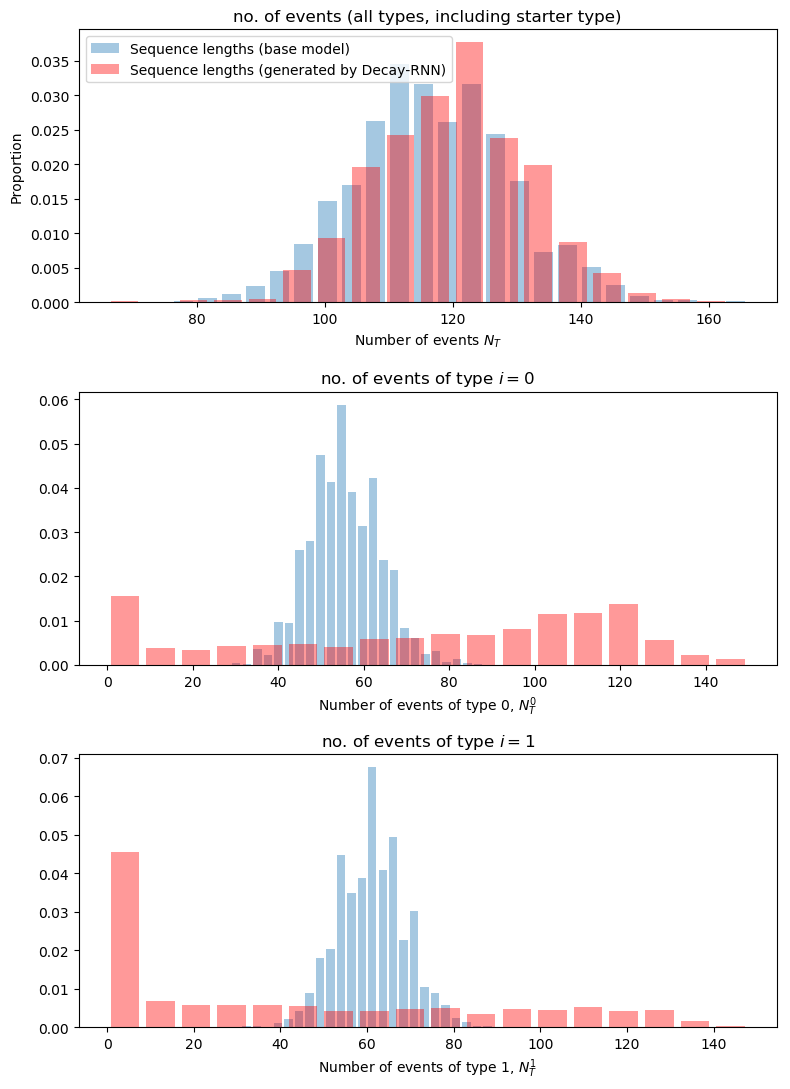

In [135]:
fig, axes = plt.subplots(process_dim + 1, 1, figsize=(8,5+process_dim*3), dpi=100)
ax0 = axes[0]
axt = axes[1:]
hist_opts = {
    "rwidth": 0.8,
    "alpha": 0.4,
    "density": True
}

_ = ax0.hist(seq_lengths, bins=2*int(seq_lengths.size(0)**(1/3)),
            label="Sequence lengths (base model)",
            **hist_opts)
_ = ax0.hist(gen_seq_lengths, bins=2*int(n_gen_seq**(1/3)),
            label="Sequence lengths (generated by {:})".format(MODEL_NAME),
            color='red', **hist_opts)
ax0.legend()
ax0.set_title('no. of events (all types, including starter type)')
ax0.set_ylabel('Proportion')
ax0.set_xlabel('Number of events $N_T$')
for i, ax in enumerate(axt):
    # get the sequence lengths for the event types
    typ_seq_lengths = (seq_types == i).sum(dim=0)
    gen_typ_seq_lengths = gen_seq_types_lengths[:, i]
    ax.hist(typ_seq_lengths, bins=2*int(typ_seq_lengths.size(0)**(1/3)),
            label="Sequence lengths (base model)",
            **hist_opts)
    ax.hist(gen_typ_seq_lengths,
            bins=2*int(gen_typ_seq_lengths.shape[0]**(1/3)),
            label="Sequence lengths (base model)",
            color='red', **hist_opts)
    ax.set_xlabel("Number of events of type {}, $N_T^{}$".format(i, i))
    ax.set_title('no. of events of type $i={}$'.format(i))

fig.tight_layout()

In [139]:
RESULT_BASEDIR = "../results"
extra_tag = "{}d".format(process_dim)
os.makedirs(RESULT_BASEDIR, exist_ok=True)
model_perf_indicator = "seq_length_distrib"
fig.savefig("{:}/{:}_{:}-{}-hidden_{}.pdf"
            .format(RESULT_BASEDIR, model_perf_indicator, MODEL_NAME, extra_tag, hidden_size))

The number of events does not fit.

In [136]:
def plot_events_and_intensity(event_times: torch.Tensor, seq_types: torch.Tensor,
                              hidden_states: torch.Tensor, event_decay: torch.Tensor):
    sequence_length = event_times.shape[0]
    print("no. of events: {}".format(sequence_length))
    evt_times = event_times.numpy()
    evt_types = seq_types.numpy()
    inp_size = model.input_size
    fig, ax = plt.subplots(1, 1, sharex=True, dpi=110,
                           figsize=(10,1))
    ax.set_ylim((-0.6, 1.6))
    ts_y = np.random.rand(sequence_length)
    inpt_size = model.input_size
    for k in range(inpt_size):
        mask = evt_types == k
        ax.scatter(evt_times[mask], ts_y[mask], s=9,
                   label="{}".format(k), alpha=0.7)
        ax.vlines(evt_times[mask], -0.6, 1.6, linewidth=0.3, linestyles='--', alpha=0.5)
    ax.legend()

no. of events: 143


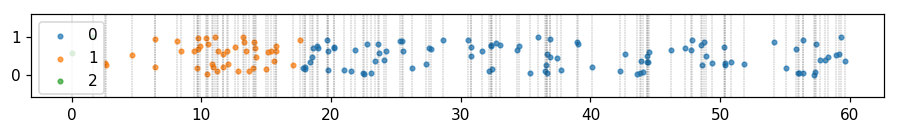

In [137]:
gen_evt_times, gen_evt_types, gen_event_intens, gen_event_decay = generate_sequence(model, tmax)
plot_events_and_intensity(gen_evt_times, gen_evt_types, gen_event_intens, gen_event_decay)

In [126]:
from models.decayrnn import read_predict
import torch.nn.functional as F

In [127]:
num_errors = 0

for index in range(500):
    oh_real, oh_pred, type_distrib = read_predict(
        model, times_tensor[:,index],
        onehot_types[:,index], seq_lengths[index])
    num_errors += int(not(oh_real.equal(oh_pred)))

In [128]:
print("Errors: {}/{}".format(num_errors, 500))

Errors: 258/500
